<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/unet_experiments_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==2.1.0
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install tqdm
!pip install accelerate
!pip install lpips

In [6]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import time
import numpy
import pickle
import os

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st
from accelerate import Accelerator

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2, InterpolationMode
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF

from miniai.datasets import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray_r'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

IMAGENET_MEAN = torch.tensor([0.4810, 0.4482, 0.3968])
IMAGENET_STD = torch.tensor([0.2760, 0.2683, 0.2813])

IN_CHANNELS_RGB = 3
IN_CHANNELS_GRAY_SCALE = 1

Mounted at /content/drive


In [7]:
import random
from torch.nn import init

def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    if len(x.shape) > 3: init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    else: init.normal_(x[:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    return x

class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

class LossMonitoringCB(Callback):
  def __init__(self):
    self.losses = [5.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 3:
      print('SOME SHIT HAPPENED')
      st()
      learn.loss.clip_(0, self.losses[-1]*3)
    self.losses.append(learn.loss.item())

act_gr = partial(GeneralRelu, leak = 0.1)
iw = partial(init_weights, leaky = 0.1)

 # Plan

 1. Data:
    1. Upscaling : 128 by 128 images from 64 * 64 images...
    2. Data Augmentation: Add same augmentation as x to y expcept for erase.

 2. Model
    1. Unet with basic cross connections.
    2. Unet with cross convs.
    3. Unet with deep layers.

 3. Loss Function
    1. Basic MSE with Feature Loss - Perceptual Loss (clarify related to no_grad pass with original y).
    2. Try and incorporate gram loss - Replace perceptual loss with gram loss and check.
    3. Try combination of all 3.

 4. Optimization Function - AdamW with no weight decay.

# Data

In [ ]:
!wget 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
!unzip tiny-imagenet-200.zip

In [8]:
x_mean = IMAGENET_MEAN
x_std = IMAGENET_STD

def norm(x): return (x - x_mean[:, None, None])/(x_std[:, None, None])
def de_norm(x): return x * (x_std[:, None, None]) + x_mean[:, None, None]

class UnetDS:
  def __init__(self, im_paths, tfms = [], ptfms_x = [RandErase(max_num = 4)], ptfms_y = [], im_size = 64):
    fc.store_attr()
    self.tfms = self.prepare_tfms(tfms)
    self.ptfms_x, self.ptfms_y = v2.Compose(ptfms_x), v2.Compose(ptfms_y)

  def prepare_tfms(self, tfms = None):
    if tfms: return v2.Compose(tfms)
    else: return v2.Compose(
        [
            v2.RandomHorizontalFlip(p = 0.5),
            v2.Pad(4),
            v2.RandomCrop(size=(64, 64)),
            v2.TrivialAugmentWide(interpolation = InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            norm,
        ]
    )

  def tfm_x(self, x):
    targ_size = self.im_size//2
    resized_imt = TF.resize(x, (targ_size, targ_size), antialias = True)[None]
    return self.ptfms_x(F.interpolate(resized_imt, scale_factor= 2)[0])

  def tfm_y(self, x): return self.ptfms_y(x)

  def __getitem__(self, idx):
    im = self.tfms(Image.open(self.im_paths[idx]))
    return self.tfm_x(im), self.tfm_y(im)

  def __len__(self): return len(self.im_paths)

In [9]:
tfm = transforms.ToTensor()

def _verify_im_path(im_path):
  im = Image.open(im_path)
  im_t = tfm(im)
  del im
  if im_t.shape[0] == 1: return False
  return True

def verify_ims(im_paths):
  verified_paths = []
  for i in im_paths:
    if _verify_im_path(i): verified_paths.append(i)
  return verified_paths

def get_train_d(path, limit = None):
  im_paths, classes = [], []
  for i in tqdm(path.ls()):
    cla = i.name
    ps = (i/'images').ls()
    if limit != None: ps = ps[:limit]
    ims = verify_ims(ps)
    im_paths += ims
    classes += [cla]*len(ims)
  return im_paths, classes

def get_valid_d(path):
  paths, classes = [], []
  with open(path/"val_annotations.txt", 'r') as f:
    for i in tqdm(f.read().splitlines()):
      im_path = path/'images'/i.split()[0]
      if _verify_im_path(im_path):
        paths.append(im_path)
        classes.append(i.split()[1])
  return paths, classes

In [10]:
def collate_fn(some):
  x, y = zip(*some)
  return torch.stack(x, dim = 0), torch.stack(y, dim = 0)

with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/train_ds_unet_s.pkl', 'rb') as f: train_ds = pickle.load(f)
with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/valid_ds_unet_s.pkl', 'rb') as f: valid_ds = pickle.load(f)

valid_ds.ptfms_x = fc.noop

dlf = partial(DataLoader, batch_size = 256, shuffle = True, num_workers = 2, collate_fn = collate_fn)
train_dl, valid_dl = dlf(train_ds), dlf(valid_ds)

In [7]:
train_im_paths, train_labels = get_train_d(Path('tiny-imagenet-200/train'), limit = 40)
valid_paths, valid_classes = get_valid_d(Path('tiny-imagenet-200/val'))

 90%|█████████ | 180/200 [00:06<00:00, 25.83it/s]


KeyboardInterrupt: 

In [ ]:
train_ds = UnetDS(im_paths = train_im_paths, ptfms_x = [RandErase(max_num = 4)], ptfms_y = [], im_size = 64)
valid_ds = UnetDS(im_paths = valid_paths, ptfms_x = [RandErase(max_num = 4)], ptfms_y = [], im_size = 64)
len(train_ds), len(valid_ds)

In [ ]:
x, y = train_ds[10]
show_images([de_norm(x), de_norm(y)])

In [ ]:
with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/train_ds_unet_s.pkl', 'wb') as f: pickle.dump(train_ds, f)
with open('/content/drive/MyDrive/fastai_p2/tiny_img_net/dls/valid_ds_unet_s.pkl', 'wb') as f: pickle.dump(valid_ds, f)

In [ ]:
def collate_fn(some):
  x, y = zip(*some)
  return torch.stack(x, dim = 0), torch.stack(y, dim = 0)
dlf = partial(DataLoader, batch_size = 256, shuffle = True, num_workers = 2, collate_fn = collate_fn)
train_dl, valid_dl = dlf(train_ds), dlf(valid_ds)
x, y = next(iter(train_dl))

In [ ]:
show_images([de_norm(i) for i in x[:9]])

In [ ]:
show_images([de_norm(i) for i in y[:9]])

# Class Definitions

In [11]:
def _pre_conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = []
  if act: layers.append(act())
  if norm: layers.append(norm(ni) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a layer norm.
  layers.append(nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias))
  return nn.Sequential(*layers)

class PreActResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        _pre_conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        _pre_conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = _pre_conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)
      nn.init.constant_(self.pf[-1].bias, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x):
    return self.conserve(x) + self.play(x)

  def __name__(self):
    return 'PreResBlock'

def blocks(ni, nf, nls = 1, block = PreActResBlock, stride = 1, ks = 3, act = GeneralRelu):
  return nn.Sequential(*[block(ni if i == 0 else nf, nf, stride = stride if i == 0 else 1, ks = ks, act = act) for i in range(nls)])

def hook_fn(mod, inp, out, hook_obj): hook_obj.data = out

class Hook:
  def __init__(self, layer):
    self.data = None
    self.hook = layer.register_forward_hook(partial(hook_fn, hook_obj = self))

  def remove(self): self.hook.remove()
  def __del__(self): self.remove()

class UpBlock(nn.Module):
  def __init__(self, ni, nf, ks = 3, nls = 1, scale_factor = 2, act = GeneralRelu):
    super().__init__()
    self.up = nn.Sequential(nn.UpsamplingBilinear2d(scale_factor = scale_factor), PreActResBlock(ni, nf, stride = 1, ks = ks, act = act))
    self.blocks = blocks(nf, nf, nls = nls, stride = 1, ks = ks, act = act)

  def forward(self, x, cross_acts = None):
    out = self.up(x)
    if cross_acts != None: out += cross_acts
    return self.blocks(out)

class UNET(nn.Module):

  def __init__(self, size = 64, nfs = [64, 128, 256, 512], nls = 1, in_channels = IN_CHANNELS_RGB, act = GeneralRelu):
    super().__init__()
    down = [blocks(in_channels, nfs[0], nls = nls, stride = 1, ks = 7, act = act)] + [blocks(nfs[i], nfs[i+1], stride = 2, act = act) for i in range(len(nfs)-1)]
    self.down = nn.Sequential(*down)
    self.inter = PreActResBlock(nfs[-1], nfs[-1], stride = 1, act = act)
    self.up = nn.Sequential(*[UpBlock(nfs[i], nfs[i-1], nls = nls, act = act) for i in range(len(nfs) - 1, 0, -1)])

    self.hooks = [Hook(i) for i in reversed(self.down[:-1])]
    self.pre_fin = blocks(ni = nfs[0], nf = IN_CHANNELS_RGB, stride = 1, nls = nls, act = act)
    self.fin = nn.Sequential(nn.Conv2d(IN_CHANNELS_RGB, IN_CHANNELS_RGB, stride = 1, kernel_size=(3, 3), padding = 1),
                             PreActResBlock(IN_CHANNELS_RGB, IN_CHANNELS_RGB, act = act, stride = 1))

  def forward(self, x):
    out = self.inter(self.down(x))
    for i, b in enumerate(self.up): out = b(out, cross_acts = self.hooks[i].data)
    out = self.pre_fin(out)
    return self.fin(out + x)

class FeatureLoss():
  def __init__(self, layers = (10), metric_func = F.mse_loss, scale_factor = 0.1):
    fc.store_attr()
    self.model = torch.load(mdl_path/"50_epoch_pre_act_early_tipoff.pkl", map_location = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    self.set_up()

  def set_up(self):
    last_layer = max(self.layers)

    # Delete the unnecessary layers
    for i in range(len(self.model) - 1 - last_layer): del self.model[-1]

    # Attack Hooks for all the required layers
    self.hooks = [Hook(self.model[i]) for i in self.layers]
    # self.scale_factor *= (1/len(self.layers))

  def norm(self, x): return (x - x.mean())/x.std()

  def get_acts(self, inp):
    self.model(inp)
    return [self.norm(hook.data) for hook in self.hooks]

  def __call__(self, yhat, y):
    with torch.no_grad(), torch.autocast('cuda'):
      y_vals = self.get_acts(y)
      yhat_vals = self.get_acts(yhat)
    loss = F.mse_loss(yhat, y)
    for yh, yo in zip(yhat_vals, y_vals): loss += self.metric_func(yh, yo)*self.scale_factor

    # print(loss.item())
    return loss

class UNETV2(nn.Module):

  def __init__(self, size = 64, nfs = [64, 128, 256, 512], nls = 1, in_channels = IN_CHANNELS_RGB, act = GeneralRelu):
    super().__init__()
    down = [blocks(in_channels, nfs[0], nls = nls, stride = 1, ks = 7, act = act)] + [blocks(nfs[i], nfs[i+1], stride = 2, act = act) for i in range(len(nfs)-1)]
    self.cross = nn.ModuleList([blocks(i, i, nls = nls, stride = 1, ks = 3, act = act) for i in [in_channels] + nfs[:-1]])
    self.down = nn.Sequential(*down)
    self.inter = PreActResBlock(nfs[-1], nfs[-1], stride = 1, act = act)
    self.up = nn.Sequential(*[UpBlock(nfs[i], nfs[i-1], nls = nls, act = act) for i in range(len(nfs) - 1, 0, -1)])

    self.hooks = [Hook(i) for i in reversed(self.down[:-1])]
    self.pre_fin = blocks(ni = nfs[0], nf = IN_CHANNELS_RGB, stride = 1, nls = nls, act = act)
    self.fin = nn.Sequential(nn.Conv2d(IN_CHANNELS_RGB, IN_CHANNELS_RGB, stride = 1, kernel_size=(3, 3), padding = 1),
                             PreActResBlock(IN_CHANNELS_RGB, IN_CHANNELS_RGB, act = act, stride = 1))

  def forward(self, x):
    out = self.inter(self.down(x))
    cross_data = [self.cross[0](x)]
    for i, h in enumerate(reversed(self.hooks)): cross_data.append(self.cross[i+1](h.data))

    cross_data = list(reversed(cross_data))

    for i, b in enumerate(self.up): out = b(out, cross_acts = cross_data[i])
    out = self.pre_fin(out)
    return self.fin(out + cross_data[-1])

class FeatureLossV2(FeatureLoss):

  def norm(self, x):
    mean = x.mean((0, 2, 3))
    std = x.std((0, 2, 3))
    return (x - mean[None, :, None, None])/std[None, :, None, None]

class CombinedLoss:
  def __init__(self, loss_functions = [F.mse_loss]): fc.store_attr()
  def __call__(self, x, y):
    l = 0.
    for lf in self.loss_functions: l += lf(x, y)
    return l

class GLoss:
  def __init__(self, scale_factor = 0.1):
    self.scale = scale_factor
    c = torch.tensor([[[-1, 0, 0], [0, 1, 0], [0, 0, 0]],
                           [[0, -1, 0], [0, 1, 0], [0, 0, 0]],
                           [[0, 0, -1], [0, 1, 0], [0, 0, 0]],
                           [[0, 0, 0], [-1, 1, 0], [0, 0, 0]],
                           [[0, 0, 0], [0, 1, -1], [0, 0, 0]],
                           [[0, 0, 0], [0, 1, 0], [-1, 0, 0]],
                           [[0, 0, 0], [0, 1, 0], [0, -1, 0]],
                           [[0, 0, 0], [0, 1, 0], [0, 0, -1]]]).float().requires_grad_(False).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    self.c = c[:, None, :, :].repeat((1, 3, 1, 1))

  def __call__(self, x, y):
    xg = F.conv2d(x, self.c, stride = 1)
    with torch.no_grad(): yg = F.conv2d(y, self.c, stride = 1)
    return F.mse_loss(xg, yg) * self.scale

# Experiment - 1

In [ ]:
dlf = partial(DataLoader, batch_size = 64, shuffle = True, num_workers = 2, collate_fn = collate_fn)
train_dl, valid_dl = dlf(train_ds), dlf(valid_ds)
dls = DataLoaders(train_dl, valid_dl)
lr_max, epochs = 4e-03, 10
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]

model = unet = UNET(act = act_gr)
learner = AccLearner(model, dls, loss_func = FeatureLoss(layers = (10, 14), scale_factor = 0.01), lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

In [ ]:
del learner
del model
del dls
clean_mem()

In [ ]:
torch.save(learner.model, mdl_path/'unet_v1.pkl')

In [ ]:
model = torch.load(mdl_path/'unet_v1.pkl')

In [ ]:
x, y = next(iter(train_dl))

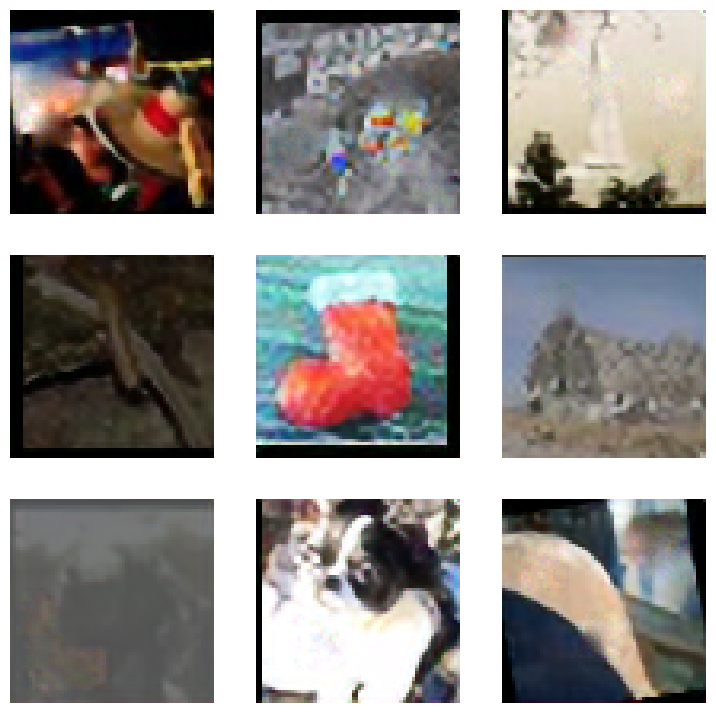

In [ ]:
x = x[:9]
out = model(x.to(torch.device('cuda')))
show_images(de_norm(out.cpu())[:9])

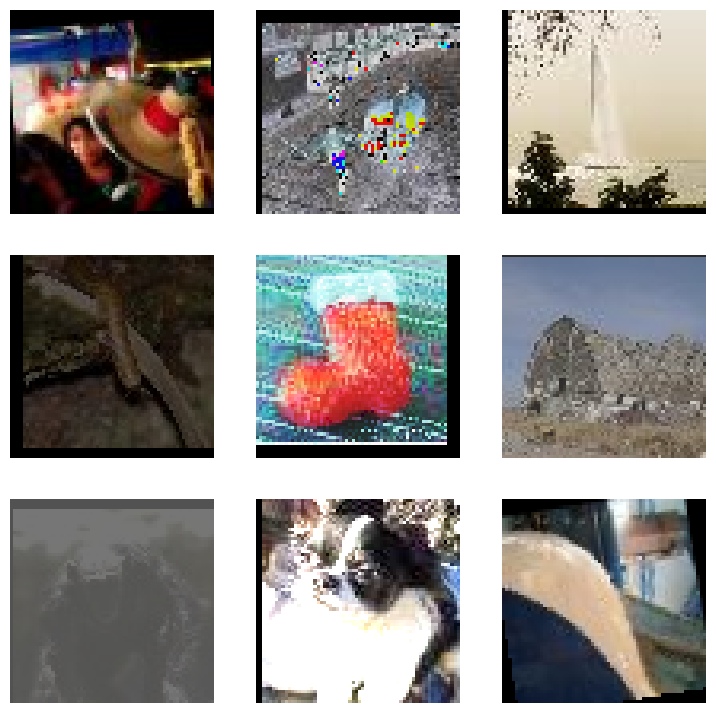

In [ ]:
show_images(de_norm(y.cpu())[:9])

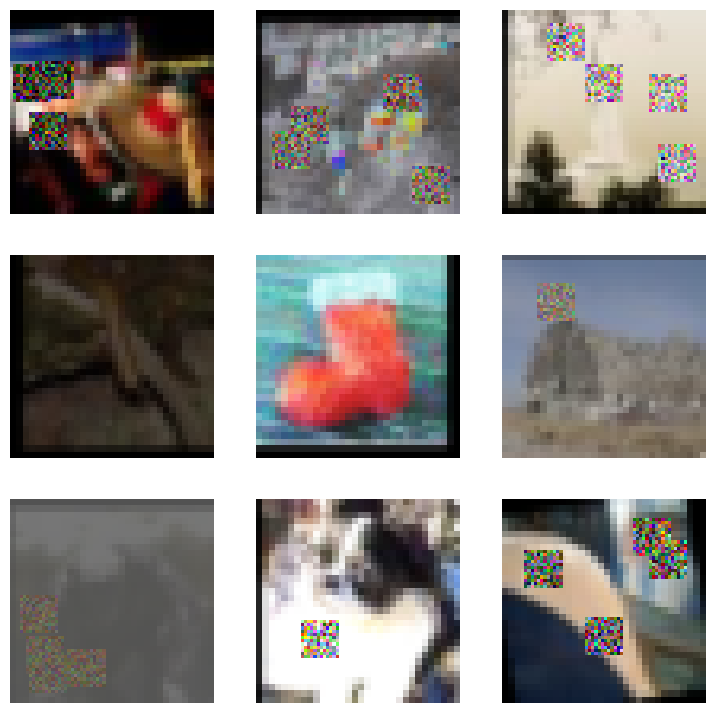

In [ ]:
show_images(de_norm(x.cpu())[:9])

# Experiment with UNET - V2 (Cross Convs)

loss,epoch,train
0.404,0,train
0.204,0,eval
0.174,1,train
0.143,1,eval
0.138,2,train
0.122,2,eval
0.121,3,train
0.110,3,eval
0.111,4,train
0.105,4,eval


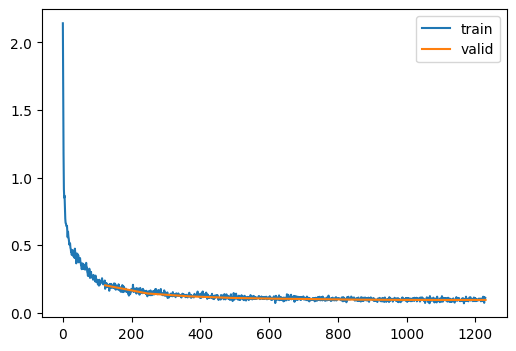

In [ ]:
dlf = partial(DataLoader, batch_size = 64, shuffle = True, num_workers = 2, collate_fn = collate_fn)
train_dl, valid_dl = dlf(train_ds), dlf(valid_ds)
dls = DataLoaders(train_dl, valid_dl)
lr_max, epochs = 1e-03, 10
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          LossMonitoringCB()
      ]

model = UNETV2(act = act_gr)
learner = AccLearner(model, dls, loss_func = FeatureLoss(layers = (10, 14), scale_factor = 0.01), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-05))
learner.fit(epochs)

In [ ]:
del dls
del model
del learner
clean_mem()

In [ ]:
x, y = next(iter(train_dl))

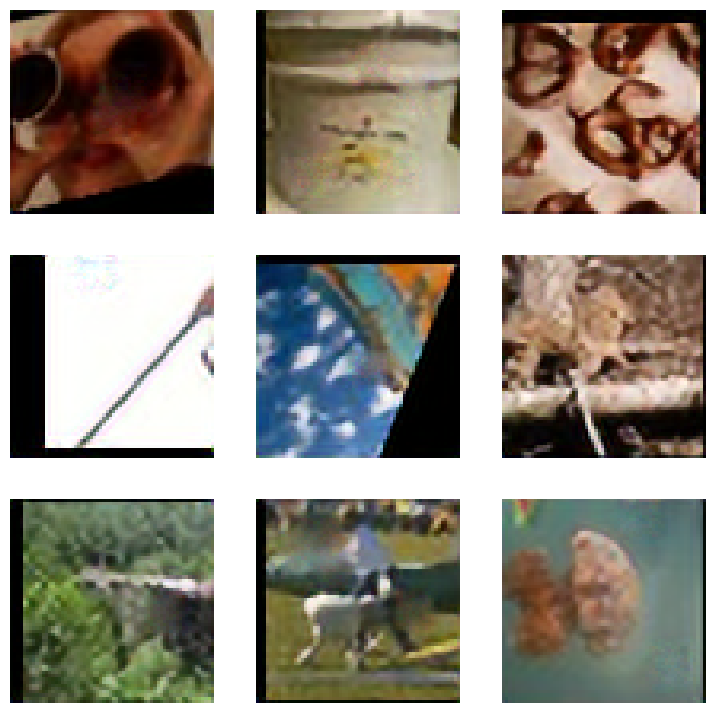

In [ ]:
x = x[:9]
out = learner.model(x.to(torch.device('cuda')))
show_images(de_norm(out.cpu())[:9])

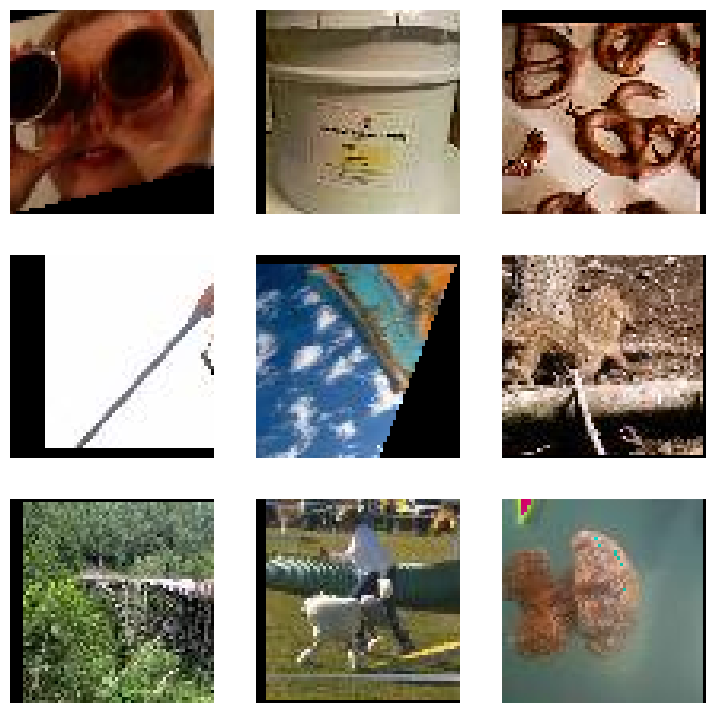

In [ ]:
show_images(de_norm(y.cpu())[:9])

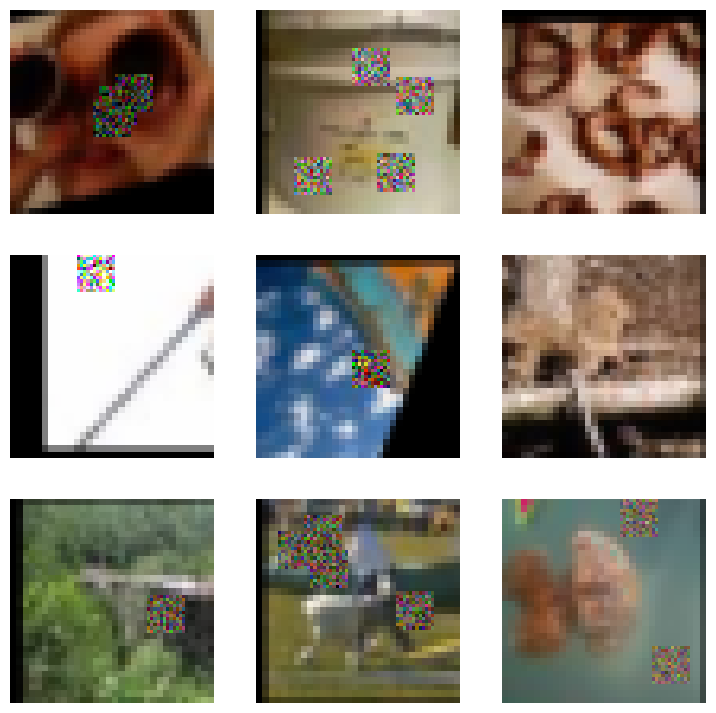

In [ ]:
show_images(de_norm(x.cpu())[:9])

In [17]:
model = UNETV2(act = act_gr)
model_2 = UNETV2(act = act_gr).apply(iw)

In [ ]:
for i, j in zip(model.parameters(), model_2.parameters()):
  try:
    if len(i.shape) == 1: continue
    print(f'{i.shape} :: orig: {i.mean(): .4f}, {i.std(): .4f}, {i.min(): .4f}, {i.max(): .4f}         kaiming: {j.mean(): .4f}, {j.std(): .4f}, {j.min(): .4f}, {j.max(): .4f}')
  except:
    continue

In [89]:
x, y = next(iter(train_dl))

In [25]:
x.shape

torch.Size([256, 3, 64, 64])

In [26]:
m = PreActResBlock(3, 16, stride = 2, ks = 3)

In [27]:
out = m(x)

In [28]:
out.shape

torch.Size([256, 16, 32, 32])

In [29]:
x.mean(), x.std(), x.max(), x.min()

(tensor(-0.2223), tensor(1.0100), tensor(2.1443), tensor(-1.7428))

In [30]:
out.mean(), out.std(), out.max(), out.min()

(tensor(-0.0205, grad_fn=<MeanBackward0>),
 tensor(0.8070, grad_fn=<StdBackward0>),
 tensor(5.1091, grad_fn=<MaxBackward1>),
 tensor(-6.5147, grad_fn=<MinBackward1>))

In [33]:
n = PreActResBlock(3, 16, stride = 2, ks = 3)
nout = n(x)
nout.mean(), nout.std(), nout.max(), nout.min()

(tensor(-0.1278, grad_fn=<MeanBackward0>),
 tensor(2.4977, grad_fn=<StdBackward0>),
 tensor(21.8577, grad_fn=<MaxBackward1>),
 tensor(-18.4141, grad_fn=<MinBackward1>))

In [ ]:
iw = partial(init_weights, leaky = 0.1)

In [34]:
??init_weights

In [35]:
?? init.kaiming_normal_

In [45]:
def init_weights(m, leaky=0., mode = 'fan_in'):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky, mode = mode)

iw = partial(init_weights, mode = 'fan_in', leaky = 0.1)

In [46]:
n = PreActResBlock(3, 16, stride = 2, ks = 3).apply(iw)
nout = n(x)
nout.mean(), nout.std(), nout.max(), nout.min()

(tensor(-0.0068, grad_fn=<MeanBackward0>),
 tensor(2.2499, grad_fn=<StdBackward0>),
 tensor(19.3999, grad_fn=<MaxBackward1>),
 tensor(-20.8411, grad_fn=<MinBackward1>))

In [18]:
con = nn.Conv2d(3, 6, stride = 2, kernel_size=3)

In [ ]:
con.weight

In [22]:
x = x[:4]
x.mean(), x.std()

(tensor(-0.3556), tensor(0.9026))

In [86]:
x = torch.randn(4, 3, 64, 64)

In [24]:
x.mean(), x.std()

(tensor(-0.0017), tensor(0.9983))

In [26]:
out = con(x)
out.mean(), out.std()

(tensor(-0.0176, grad_fn=<MeanBackward0>),
 tensor(0.5968, grad_fn=<StdBackward0>))

In [71]:
con = nn.Conv2d(3, 64, stride = 2, kernel_size=3)
con.weight.data = con.weight.data * (2/math.sqrt(4/3))

In [72]:
out = con(x)
out.mean(), out.std()

(tensor(-0.0033, grad_fn=<MeanBackward0>),
 tensor(1.0033, grad_fn=<StdBackward0>))

In [73]:
con = nn.Conv2d(64, 128, stride = 2, kernel_size=3)
con.weight.data = con.weight.data * (2/math.sqrt(4/3))
nout = con(out)
nout.mean(), nout.std()

(tensor(0.0063, grad_fn=<MeanBackward0>),
 tensor(1.0056, grad_fn=<StdBackward0>))

In [124]:
def iw(mod):
  if isinstance(mod, nn.Conv2d):  mod.weight.data = mod.weight.data * (2/math.sqrt(4/5))

model = nn.Sequential(nn.Conv2d(3, 64, stride = 1, kernel_size = 7),
                      act_gr(),
                      nn.Conv2d(64, 128, stride = 2, kernel_size=3),
                      act_gr(),
                      nn.Conv2d(128, 256, stride = 2, kernel_size=3),
                      act_gr(),
                      nn.Conv2d(256, 512, stride = 2, kernel_size=3)).apply(iw)
out = model(x)
out.shape, out.mean(), out.std(), out.max(), out.min()

(torch.Size([64, 512, 6, 6]),
 tensor(-0.0032, grad_fn=<MeanBackward0>),
 tensor(0.9851, grad_fn=<StdBackward0>),
 tensor(5.6858, grad_fn=<MaxBackward1>),
 tensor(-5.7779, grad_fn=<MinBackward1>))

In [138]:
x = x[:16]

In [148]:
model = nn.Sequential(PreActResBlock(3, 64, stride = 1, ks = 7),
                      PreActResBlock(64, 128, stride = 2, ks=3),
                      PreActResBlock(128, 256, stride = 2, ks=3),
                      PreActResBlock(256, 512, stride = 2, ks=3))

In [149]:
out = model(x)
out.shape, out.mean(), out.std(), out.max(), out.min()

(torch.Size([16, 512, 8, 8]),
 tensor(-0.0015, grad_fn=<MeanBackward0>),
 tensor(0.6285, grad_fn=<StdBackward0>),
 tensor(3.8841, grad_fn=<MaxBackward1>),
 tensor(-4.1005, grad_fn=<MinBackward1>))

In [ ]:
class PreActResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        _pre_conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        _pre_conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = _pre_conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)
      nn.init.constant_(self.pf[-1].bias, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x):
    return self.conserve(x) + self.play(x)

  def __name__(self):
    return 'PreResBlock'

# G Loss + Perceptual Loss

In [94]:
c = torch.tensor([[[-1, 0, 0], [0, 1, 0], [0, 0, 0]],
                           [[0, -1, 0], [0, 1, 0], [0, 0, 0]],
                           [[0, 0, -1], [0, 1, 0], [0, 0, 0]],
                           [[0, 0, 0], [-1, 1, 0], [0, 0, 0]],
                           [[0, 0, 0], [0, 1, -1], [0, 0, 0]],
                           [[0, 0, 0], [0, 1, 0], [-1, 0, 0]],
                           [[0, 0, 0], [0, 1, 0], [0, -1, 0]],
                           [[0, 0, 0], [0, 1, 0], [0, 0, -1]]]).float()

c = c[:, None, :, :].repeat((1, 3, 1, 1))
# c.requires_grad_(False)

In [105]:
x, y = nn.Parameter(torch.randn(4, 3, 64, 64)), torch.randn(4, 3, 64, 64)

In [ ]:
for i in range(5000):
  xg = F.conv2d(x, c, stride = 1)
  with torch.no_grad(): yg = F.conv2d(y, c, stride = 1)
  loss = F.mse_loss(xg, yg)
  if i%100 == 0: print(loss.item())
  loss.backward()
  x.data.sub_(x.grad  * 3)
  x.grad.data.zero_()

In [107]:
class GLoss:
  def __init__(self):
    c = torch.tensor([[[-1, 0, 0], [0, 1, 0], [0, 0, 0]],
                           [[0, -1, 0], [0, 1, 0], [0, 0, 0]],
                           [[0, 0, -1], [0, 1, 0], [0, 0, 0]],
                           [[0, 0, 0], [-1, 1, 0], [0, 0, 0]],
                           [[0, 0, 0], [0, 1, -1], [0, 0, 0]],
                           [[0, 0, 0], [0, 1, 0], [-1, 0, 0]],
                           [[0, 0, 0], [0, 1, 0], [0, -1, 0]],
                           [[0, 0, 0], [0, 1, 0], [0, 0, -1]]]).float().requires_grad_(False)
    self.c = c[:, None, :, :].repeat((1, 3, 1, 1))

  def __call__(self, x, y):
    xg = F.conv2d(x, self.c, stride = 1)
    with torch.no_grad(): yg = F.conv2d(y, self.c, stride = 1)
    return F.mse_loss(xg, yg)

In [118]:
class CombinedLoss:
  def __init__(self, loss_functions = [F.mse_loss]): fc.store_attr()
  def __call__(self, x, y):
    l = 0.
    for lf in self.loss_functions: l += lf(x, y)
    return l

In [ ]:
lf = CombinedLoss(loss_functions = [F.mse_loss, GLoss()])
x, y = nn.Parameter(torch.randn(4, 3, 64, 64)), torch.randn(4, 3, 64, 64)
for i in range(25000):
  loss = lf(x, y)
  if i%1000 == 0: print(loss.item())
  loss.backward()
  x.data.sub_(x.grad  * 0.5)
  x.grad.data.zero_()

# GLoss + Perceptual Loss + LPIPS

In [27]:
import lpips

class LPIPS:
  def __init__(self, scale_factor = 1.):
    self.scale = scale_factor
    self.loss_fn_alex = lpips.LPIPS(net='alex')
  def __call__(self, x, y):
    return (self.loss_fn_alex(x.cpu(), y.cpu()).squeeze().mean()*self.scale).cuda()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


loss,epoch,train
1.431,0,train
0.842,0,eval
0.841,1,train
0.599,1,eval
0.666,2,train
0.581,2,eval
0.589,3,train
0.462,3,eval
0.535,4,train
0.456,4,eval


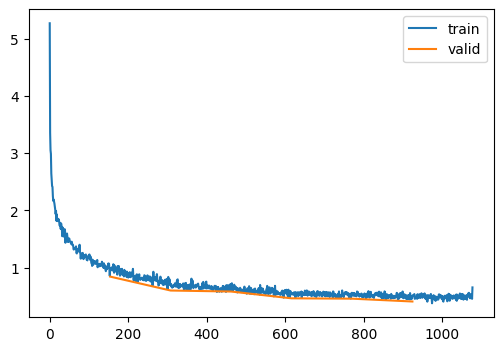

In [ ]:
dlf = partial(DataLoader, batch_size = 64, shuffle = True, num_workers = 2, collate_fn = collate_fn)
train_dl, valid_dl = dlf(train_ds), dlf(valid_ds)
dls = DataLoaders(train_dl, valid_dl)
lr_max, epochs = 8e-04, 15
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          LossMonitoringCB()
      ]

model = UNETV2(act = act_gr, nfs = [64, 128, 256, 512, 1024], nls = 2)
loss_func = CombinedLoss(loss_functions = [FeatureLossV2(layers = (5, 10, 14)), GLoss(), LPIPS()])
learner = AccLearner(model, dls, loss_func = loss_func, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-04))
learner.fit(epochs)

In [ ]:
x, y = next(iter(dls.valid))
x = x[:9]
out = learner.model(x.to(torch.device('cuda')))
show_images(de_norm(out.cpu())[:9])

In [ ]:
show_images(de_norm(y.cpu())[:9])

In [ ]:
show_images(de_norm(x.cpu())[:9])

In [28]:
del learner
del loss_func
del model
del dls
clean_mem()